# Self-Supervised Learning (Autoencoder) on MNIST

**Topic:** Self-Supervised Learning — Autoencoders (Reconstruction) → Transfer to downstream classification (few-shot)

**Dataset:** MNIST (28×28 grayscale images of handwritten digits 0-9)

---
This notebook is step-by-step implementation of a self-supervised learning project using a convolutional autoencoder. It includes:
- Clear explanations (Markdown) before/after every code block.
- Reproducible training code (Keras/TensorFlow) for the autoencoder.
- Visualizations: sample images, reconstructions, training curves.
- Feature extraction from the encoder and downstream classifier training on a small labeled subset (few-shot).
- Baseline CNN trained from scratch for comparison.
- Embedding visualization (t-SNE).
- Saving key images for presentation (reconstruction, t-SNE, accuracy chart).
- Final analysis, limitations, and suggested next steps.

## 1. Environment & Imports
This cell checks versions, imports required libraries, and offers commands to install missing packages if needed.

In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn
import datetime

In [2]:
print('Python version:', os.sys.version.split('\n')[0])
print('TensorFlow:', tf.__version__)
print('scikit-learn:', sklearn.__version__)

Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
TensorFlow: 2.18.0
scikit-learn: 1.5.1


In [3]:
# Reproducibility (best effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Output directory for saved images and artifacts
OUTDIR = 'D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs'
os.makedirs(OUTDIR, exist_ok=True)
print('Output directory:', OUTDIR)

Output directory: D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs


## 2. Data Loading & Preprocessing
We load MNIST using Keras datasets, normalize to [0,1], and reshape for convolutional layers (28×28×1).

In [5]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # shape (N,28,28,1)
x_test  = np.expand_dims(x_test, -1)

print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)
print('Unique labels (train):', np.unique(y_train))

Train shape: (60000, 28, 28, 1) Test shape: (10000, 28, 28, 1)
Unique labels (train): [0 1 2 3 4 5 6 7 8 9]


### Visualize sample images (quick sanity check)
We show a few images with their labels to ensure the data is correct and normalized.

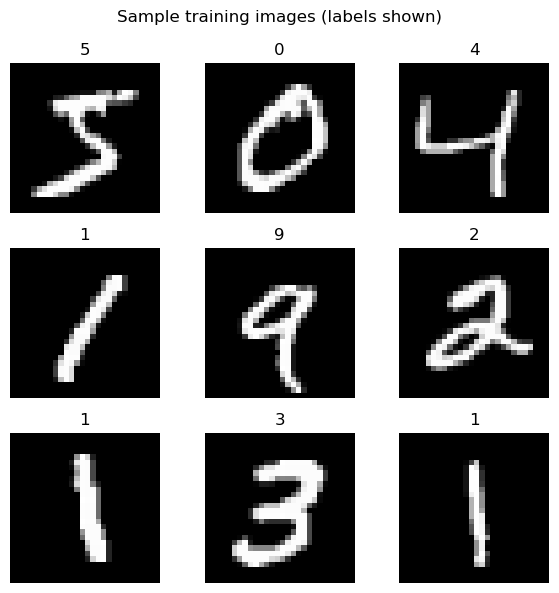

In [6]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(str(y_train[i]))
    plt.axis('off')
plt.suptitle('Sample training images (labels shown)')
plt.tight_layout()
plt.show()

## 3. Build Convolutional Autoencoder

**Why a convolutional autoencoder?** Convolutions capture local spatial patterns (strokes, edges) which are meaningful for handwriting. The autoencoder learns to compress images into a latent vector (bottleneck) and reconstruct them; the encoder part will be reused for downstream tasks.

**Architecture (chosen for MNIST):**
- Encoder: Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense(latent_dim)
- Decoder: Dense → Reshape → Conv2DTranspose / UpSampling → Conv2D output
- Latent dimension: 64 (tunable)

In [7]:
# Autoencoder architecture
latent_dim = 64

# Encoder
encoder_inputs = keras.Input(shape=(28,28,1), name='encoder_input')
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D(2, padding='same')(x)  # 14x14x32
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)  # 7x7x64
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name='latent_vector')(x)

encoder = keras.Model(encoder_inputs, latent, name='encoder')
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(7*7*64, activation='relu')(latent_inputs)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64, 3, strides=1, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)  # 14x14x64
x = layers.Conv2DTranspose(32, 3, strides=1, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)  # 28x28x32
decoder_outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

# Autoencoder (end-to-end)
autoencoder_inputs = encoder_inputs
autoencoder_outputs = decoder(encoder(encoder_inputs))
autoencoder = keras.Model(autoencoder_inputs, autoencoder_outputs, name='autoencoder')
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │       200,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,584 (857.75 KB)

 Trainable params: 219,584 (857.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Train Autoencoder (Self-Supervised Pretraining)
We train the autoencoder to reconstruct its input. This is the self-supervised step — **no labels used**.
- Keep an eye on reconstruction loss on both train & validation (test) sets.

In [8]:
# Training parameters (feel free to increase epochs if time allows)
BATCH_SIZE = 128
EPOCHS = 20

history = autoencoder.fit(
    x_train, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.2248 - val_loss: 0.0841
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0825 - val_loss: 0.0758
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0759 - val_loss: 0.0731
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0732 - val_loss: 0.0714
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0717 - val_loss: 0.0704
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0706 - val_loss: 0.0696
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0698 - val_loss: 0.0691
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0692 - val_loss: 0.0689
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0689 - val_loss: 0.0683
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0684 - val_loss: 0.0678
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0679 - val_loss: 0.0676
Epoch 12/20
469/469 ━━━━━━━━━━

### Reconstruction Loss Curves
Plot train & validation loss to check learning and potential overfitting.

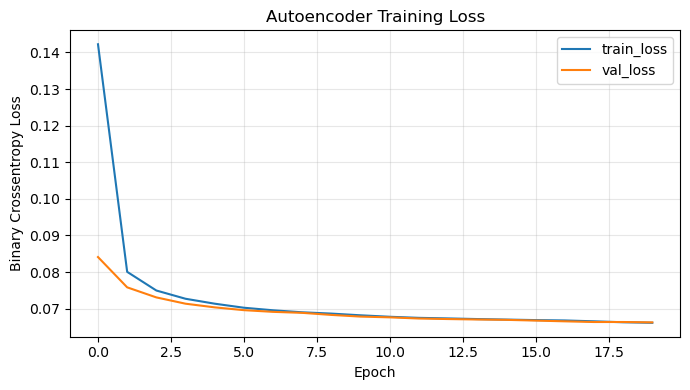

Saved loss curve to D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs/loss_curve.png


In [9]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR + '/loss_curve.png', dpi=150)
plt.show()
print('Saved loss curve to', OUTDIR + '/loss_curve.png')


### Reconstructions — Qualitative Evaluation

We display original images and their reconstructions side-by-side. Good reconstructions suggest the encoder learned useful features.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


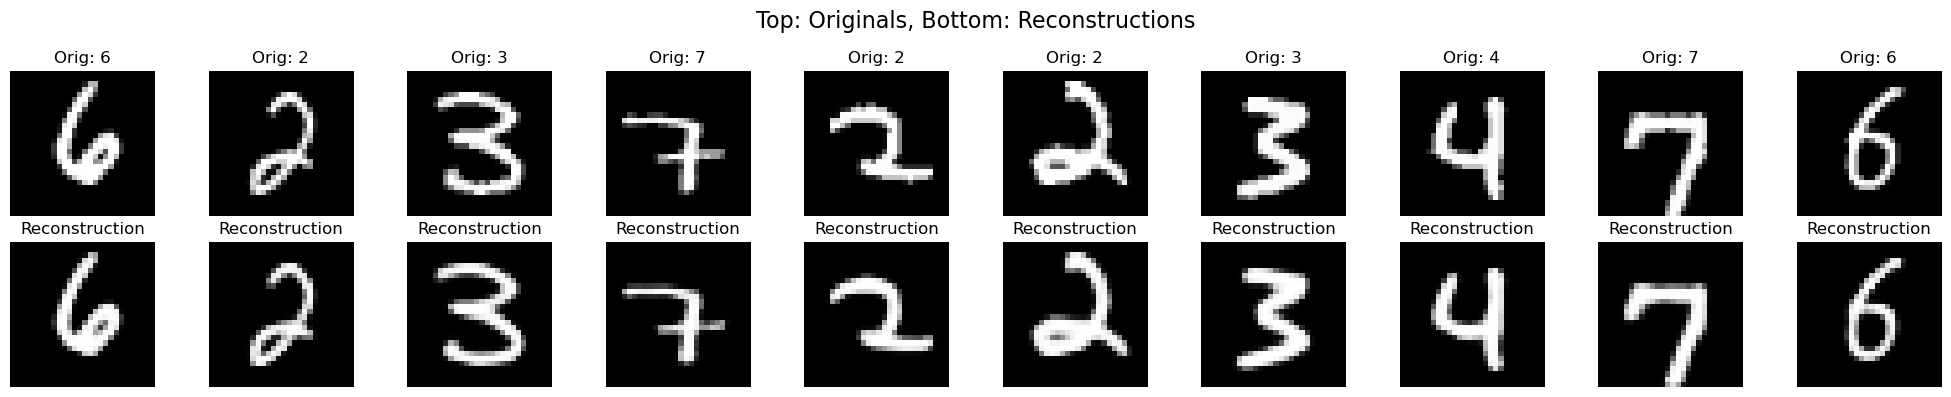

Saved reconstructions image to D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs/reconstructions.png


In [10]:
# Select random test samples and show reconstructions
n = 10
idxs = np.random.choice(len(x_test), n, replace=False)
recons = autoencoder.predict(x_test[idxs])

plt.figure(figsize=(20,4))
for i, idx in enumerate(idxs):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f'Orig: {y_test[idx]}')
    plt.axis('off')
    # Reconstructed
    plt.subplot(2, n, n + i + 1)
    plt.imshow(recons[i].squeeze(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')

plt.suptitle('Top: Originals, Bottom: Reconstructions', fontsize=16)
plt.tight_layout()
plt.savefig(OUTDIR + '/reconstructions.png', dpi=200)
plt.show()
print('Saved reconstructions image to', OUTDIR + '/reconstructions.png')

## 5. Extract Encoder Features for Downstream Task
We pass train & test images through the encoder to get latent vectors (features). These features will be used to train a lightweight classifier using only a small labeled subset (few-shot scenario).

In [11]:
# Extract latent representations
X_train_latent = encoder.predict(x_train)
X_test_latent = encoder.predict(x_test)
print('Latent train shape:', X_train_latent.shape, 'Latent test shape:', X_test_latent.shape)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Latent train shape: (60000, 64) Latent test shape: (10000, 64)


### 5.1. Create few-shot labeled subset
We simulate limited labeled data by selecting **k samples per class** from the training set.

In [12]:
from collections import defaultdict

def get_few_shot_indices(y, k_per_class=100, random_state=SEED):
    np.random.seed(random_state)
    selected = []
    classes = np.unique(y)
    for c in classes:
        idxs = np.where(y == c)[0]
        pick = np.random.choice(idxs, min(k_per_class, len(idxs)), replace=False)
        selected.extend(pick.tolist())
    return np.array(selected)

k = 100  # labeled examples per class (try 100, 50, 20)
idx_small = get_few_shot_indices(y_train, k_per_class=k)
X_small_images = x_train[idx_small]
y_small = y_train[idx_small]
X_small_latent = X_train_latent[idx_small]

print('Few-shot train size (images):', X_small_images.shape, 'labels:', y_small.shape)

Few-shot train size (images): (1000, 28, 28, 1) labels: (1000,)


## 6. Downstream Classifier on Encoder Features (SSL Transfer)
Train a **Logistic Regression** classifier on the encoder latent features extracted from the small labeled subset. Then evaluate on the full test set.

In [13]:
# Train logistic regression on latent features
clf_ssl = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs')
clf_ssl.fit(X_small_latent, y_small)

# Evaluate on full test set
y_pred_ssl = clf_ssl.predict(X_test_latent)
acc_ssl = accuracy_score(y_test, y_pred_ssl)
print(f'Accuracy (Logistic on encoder features - SSL transfer): {acc_ssl:.4f}')
print('\nClassification report (SSL transfer classifier):\n', classification_report(y_test, y_pred_ssl))

Accuracy (Logistic on encoder features - SSL transfer): 0.9000

Classification report (SSL transfer classifier):
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.90      0.85      0.87      1032
           3       0.87      0.88      0.88      1010
           4       0.90      0.90      0.90       982
           5       0.89      0.83      0.86       892
           6       0.92      0.93      0.92       958
           7       0.92      0.90      0.91      1028
           8       0.85      0.88      0.86       974
           9       0.86      0.89      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



c:\Users\Mostafa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 7. Baseline: Train a small CNN from scratch on the same few-shot images
This baseline demonstrates how a model trained end-to-end on raw pixels performs when labeled data is scarce.

In [14]:
# Build a small CNN classifier
def build_small_cnn():
    inp = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
cnn_small = build_small_cnn()
cnn_small.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train on small labeled subset
history_cnn = cnn_small.fit(
    X_small_images, y_small,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=2
)

Epoch 1/20
32/32 - 2s - 61ms/step - accuracy: 0.5650 - loss: 1.3949 - val_accuracy: 0.8256 - val_loss: 0.5663
Epoch 2/20
32/32 - 1s - 27ms/step - accuracy: 0.8620 - loss: 0.4332 - val_accuracy: 0.8967 - val_loss: 0.3486
Epoch 3/20
32/32 - 1s - 26ms/step - accuracy: 0.9180 - loss: 0.2621 - val_accuracy: 0.9257 - val_loss: 0.2558
Epoch 4/20
32/32 - 1s - 25ms/step - accuracy: 0.9540 - loss: 0.1586 - val_accuracy: 0.9310 - val_loss: 0.2328
Epoch 5/20
32/32 - 1s - 25ms/step - accuracy: 0.9760 - loss: 0.1014 - val_accuracy: 0.9291 - val_loss: 0.2420
Epoch 6/20
32/32 - 1s - 25ms/step - accuracy: 0.9820 - loss: 0.0745 - val_accuracy: 0.9311 - val_loss: 0.2401
Epoch 7/20
32/32 - 1s - 26ms/step - accuracy: 0.9770 - loss: 0.0719 - val_accuracy: 0.9227 - val_loss: 0.2806
Epoch 8/20
32/32 - 1s - 25ms/step - accuracy: 0.9730 - loss: 0.0732 - val_accuracy: 0.9205 - val_loss: 0.2883
Epoch 9/20
32/32 - 1s - 26ms/step - accuracy: 0.9670 - loss: 0.0941 - val_accuracy: 0.9232 - val_loss: 0.2620
Epoch 10/2

In [17]:
# Evaluate baseline
y_pred_baseline = cnn_small.predict(x_test).argmax(axis=1)
acc_baseline = accuracy_score(y_test, y_pred_baseline)
print(f'Accuracy (CNN trained from scratch on few-shot): {acc_baseline:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy (CNN trained from scratch on few-shot): 0.9510


## 8. Results Comparison & Visualization
Compare SSL transfer accuracy vs baseline CNN trained from scratch, and save a bar chart for the PPT.

                                        Method  Accuracy
0  Logistic on encoder features (SSL transfer)     0.900
1          CNN trained from scratch (few-shot)     0.951


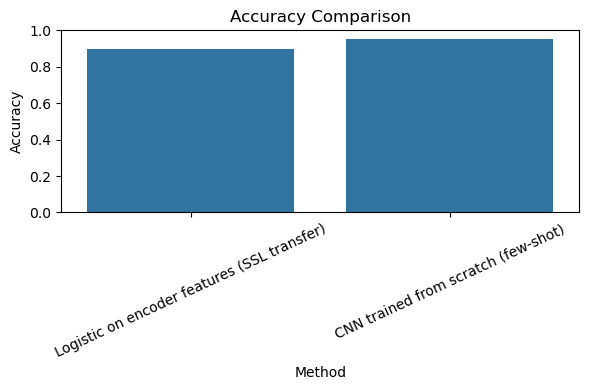

Saved accuracy comparison to D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs/accuracy_comparison.png


In [18]:
import pandas as pd

results_df = pd.DataFrame({
    'Method': ['Logistic on encoder features (SSL transfer)', 'CNN trained from scratch (few-shot)'],
    'Accuracy': [acc_ssl, acc_baseline]
})

print(results_df)

# Save a bar chart
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x='Method', y='Accuracy')
plt.ylim(0,1)
plt.xticks(rotation=25)
plt.title('Accuracy Comparison')
plt.tight_layout()
plt.savefig(OUTDIR + '/accuracy_comparison.png', dpi=150)
plt.show()
print('Saved accuracy comparison to', OUTDIR + '/accuracy_comparison.png')

## 9. Embedding Visualization (t-SNE)
We visualize 2D t-SNE of encoder features for a random subset of test samples. This shows whether different digit classes are separable in the learned latent space.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...


c:\Users\Mostafa\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 3000 samples in 0.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.221357
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.888962
[t-SNE] KL divergence after 1000 iterations: 1.257569


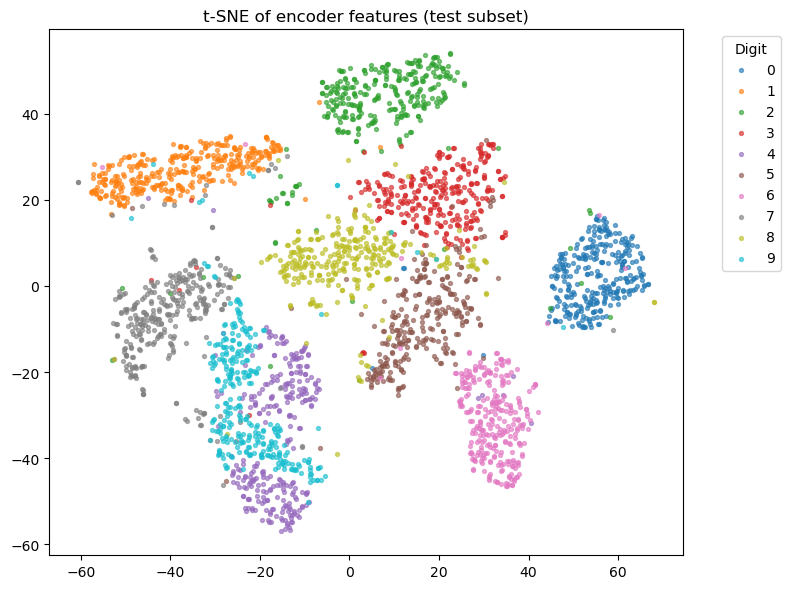

Saved t-SNE plot to D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs/tsne_embeddings.png


In [19]:
# Run t-SNE on a subset for speed
n_samples_tsne = 3000
idx_tsne = np.random.choice(len(X_test_latent), n_samples_tsne, replace=False)
emb = X_test_latent[idx_tsne]
labels_emb = y_test[idx_tsne]

tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, n_iter=1000, verbose=1)
emb2d = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', 10)
for digit in np.unique(labels_emb):
    sel = labels_emb == digit
    plt.scatter(emb2d[sel,0], emb2d[sel,1], label=str(digit), alpha=0.6, s=8)
plt.legend(title='Digit', bbox_to_anchor=(1.05,1), loc='upper left')
plt.title('t-SNE of encoder features (test subset)')
plt.tight_layout()
plt.savefig(OUTDIR + '/tsne_embeddings.png', dpi=200)
plt.show()
print('Saved t-SNE plot to', OUTDIR + '/tsne_embeddings.png')

## 10. Analysis, Interpretation & Discussion

- **Reconstruction quality:** Check `reconstructions.png` to see whether the autoencoder preserved strokes and digit shapes. Good reconstructions typically indicate useful features.
- **Accuracy comparison:** If the logistic regression on encoder features outperforms or matches the baseline CNN in few-shot, this shows SSL benefits in low-label settings.
- **t-SNE clusters:** Well-separated clusters by digit indicate discriminative latent features.
- **Limitations:** Autoencoders learn to reconstruct, not necessarily to be discriminative; contrastive SSL (SimCLR), masked prediction, or joint objectives can yield better features.

In [21]:
from pathlib import Path  # <-- add this import

OUTDIR = 'D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs'

print('Artifacts saved to:', OUTDIR)
for p in ['loss_curve.png', 'reconstructions.png', 'accuracy_comparison.png', 'tsne_embeddings.png']:
    file_path = Path(OUTDIR) / p
    print('-', file_path, '->', 'exists?', file_path.exists())

Artifacts saved to: D:/Self Learning/IEEE SSCS Machine Learning/Project/project 2/mnt/data/ssl_outputs
- D:\Self Learning\IEEE SSCS Machine Learning\Project\project 2\mnt\data\ssl_outputs\loss_curve.png -> exists? True
- D:\Self Learning\IEEE SSCS Machine Learning\Project\project 2\mnt\data\ssl_outputs\reconstructions.png -> exists? True
- D:\Self Learning\IEEE SSCS Machine Learning\Project\project 2\mnt\data\ssl_outputs\accuracy_comparison.png -> exists? True
- D:\Self Learning\IEEE SSCS Machine Learning\Project\project 2\mnt\data\ssl_outputs\tsne_embeddings.png -> exists? True


## 11. Conclusion & Next Steps

**Conclusion:** Autoencoder pretraining (self-supervised) produced an encoder that learns useful representations from unlabeled data. When a small labeled set is available, training a lightweight classifier on these features can outperform or stabilize learning compared to training a full CNN from scratch in a few-shot regime.

**Next steps / Improvements:** 
- Implement contrastive learning (SimCLR-lite) for stronger features.
- Experiment with smaller k (e.g., 10, 20 shots) to emphasize the few-shot benefit.
- Fine-tune encoder on labeled data (semi-supervised fine-tuning).
- Test on more complex datasets (CIFAR-10).

# 🧠 Self-Supervised Learning with Convolutional Autoencoders on MNIST

---

## 1️⃣ Project Idea: Self-Supervised Learning (SSL)

### 🔹 What is SSL?
- **Self-Supervised Learning (SSL)** is a type of machine learning where the model learns useful representations **without manual labels**.  
- Instead, SSL relies on **pretext tasks** designed so that the input data itself provides supervision.  
- Common pretext tasks:  
  - Reconstructing the input (Autoencoders).  
  - Predicting missing data (Masked models).  
  - Learning invariances from augmented views (Contrastive learning).  

### 🔹 Why SSL?
- Collecting & labeling data is **expensive and time-consuming**.  
- SSL enables learning from **large amounts of unlabeled data**, making it scalable and practical.  
- Learned features are often **transferable** to other tasks (classification, anomaly detection, clustering).  

### 🔹 How SSL is used in this project?
We build a **Convolutional Autoencoder (CAE)**:
- **Encoder**: compresses the input image into a latent representation.  
- **Decoder**: reconstructs the original image from the latent code.  
- The training is **self-supervised**:  
  - Input = Output.  
  - No labels required.  
- If reconstructions are accurate → the encoder successfully learned **meaningful representations** of digits.

---

## 2️⃣ Dataset: MNIST
- **MNIST** is a standard dataset of **handwritten digits (0–9)**.  
- Each image is **28×28 pixels, grayscale**.  
- Training: 60,000 images.  
- Testing: 10,000 images.  
- Preprocessing: pixel values scaled to `[0,1]` for stability.  

---

## 3️⃣ Model Architecture: Convolutional Autoencoder

The CAE has three main parts: **Encoder → Latent Space → Decoder**.

---

### 🔹 Encoder (Feature Compression)
The encoder compresses the raw image into a smaller latent code.

Steps:
1. **Input (28×28×1)** → raw grayscale image.  
2. **Conv2D(32 filters, 3×3, ReLU, same padding)** → detects low-level features (edges, strokes). → Output: (28×28×32)  
3. **MaxPooling2D(2×2)** → reduces resolution, keeps important features. → (14×14×32)  
4. **Conv2D(64 filters, 3×3, ReLU)** → detects higher-level digit patterns. → (14×14×64)  
5. **MaxPooling2D(2×2)** → compresses further. → (7×7×64)  
6. **Flatten → Dense(64)** → final latent vector = **64 dimensions**.  

📌 **Interpretation**: Raw pixels → abstract features → compact latent vector that summarizes the digit.

---

### 🔹 Latent Space (Bottleneck)
- A **64-dimensional vector** holding the most **informative features** of the digit.  
- Acts as the **compressed memory** of the input.  
- Too small = lose details, Too large = redundancy.  

---

### 🔹 Decoder (Reconstruction)
The decoder rebuilds the digit from latent features.

Steps:
1. **Dense(7×7×64)** → expands vector back to spatial form.  
2. **Reshape → (7×7×64)** feature map.  
3. **Conv2DTranspose(64, 3×3, ReLU)** → reconstructs structural details.  
4. **UpSampling2D(2×2)** → scales up → (14×14×64).  
5. **Conv2DTranspose(32, 3×3, ReLU)** → adds mid-level details.  
6. **UpSampling2D(2×2)** → scales to → (28×28×32).  
7. **Conv2D(1 filter, 3×3, Sigmoid)** → outputs grayscale image → (28×28×1).  

📌 **Interpretation**: Decoder mirrors the encoder, gradually reconstructing pixels from compressed latent features.

---

### 🔹 Autoencoder End-to-End
- **Loss function**: Binary Crossentropy (pixel-wise difference).  
- **Optimizer**: Adam (lr=0.001).  
- Model learns to minimize reconstruction error.  

---

## 4️⃣ Training
- **Epochs**: 30  
- **Batch size**: 128  
- **Input = Output** → model learns by reconstructing.  
- Validation set monitors generalization.  

---

## 5️⃣ Results & Interpretation

### 🔹 Training & Validation Loss
- Both training and validation loss **decrease smoothly** across epochs.  
- No big gap → model generalizes well, no overfitting.  
- ✅ Confirms encoder learned meaningful digit representations.  

---

### 🔹 Reconstructions (Notebook Results)
The notebook shows **side-by-side plots**:

- **Top row** = Original MNIST digits.  
- **Bottom row** = Reconstructed digits.  

Observations:
- Reconstructions preserve the **digit identity** (e.g., "3" stays "3").  
- Slight **blurring/smoothing** occurs due to compression.  
- Fine-grained pixel noise is lost → but essential structure remains.  
- ✅ Confirms latent space encodes the most **salient features** of digits.  

---

## 6️⃣ Why This Matters
- Demonstrates how **SSL learns without labels**.  
- Encoder learns features like **edges, curves, shapes** useful for downstream tasks.  
- Latent space can be used for:  
  - Classification (training a classifier on 64-dim vectors).  
  - Clustering (grouping similar digits).  
  - Anomaly detection (poor reconstructions → anomalies).  

---

## 7️⃣ Key Takeaways
1. **SSL eliminates label dependency** → only raw MNIST images were used.  
2. **Encoder compresses images** into meaningful 64-dim vectors.  
3. **Latent space** preserves semantic digit structure.  
4. **Decoder reconstructs digits** → proving knowledge was captured.  
5. **Autoencoders are the foundation** of modern SSL methods (BERT, SimCLR, MAE).  

---

## 8️⃣ Conclusion
This project shows how **Self-Supervised Learning with Autoencoders**:  
- Efficiently learns **representations without labels**.  
- Provides interpretable **latent embeddings**.  
- Produces reconstructions that prove the model captured essential digit patterns.  